In [1]:
import mplfinance as mpf
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

In [2]:
def get_time_series():
    API_key = 'MCO3JQL81ATB1YZ0'
    time = TimeSeries(key = API_key,output_format='pandas')
    return time

In [3]:
def average(lst):
    if len(lst):
        return sum(lst) / len(lst)
    else:
        return sum(lst)

In [4]:
def get_data_frame(ticker, cash, vwap=0, twap=0):
    time = get_time_series()
    data = time.get_intraday(symbol=ticker,interval='1min',outputsize='full')
    df = data[0]
    df = df.rename(columns={"1. open":"Open","2. high":"High","3. low":"Low","4. close":"Close","5. volume":"Volume"})
    result = [group[1] for group in df.groupby(df.index.day)]
    
    for index, dataframe in enumerate(result):
        index += 1
        
        dataframe = dataframe.loc[(dataframe.index.hour >= 9)]
        dataframe = dataframe.loc[(dataframe.index.hour <= 15)]
        dataframe = dataframe.resample('5T').agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'})
        
        
        if vwap:    
            dataframe['VWAP'] = (((dataframe['High']+dataframe['Low']+dataframe['Close'])*dataframe['Volume']/3).cumsum())/dataframe['Volume'].cumsum()
        if twap:
            df_open = dataframe['Open'].tolist()
            df_high = dataframe['High'].tolist()
            df_low = dataframe['Low'].tolist()
            df_close = dataframe['Close'].tolist()
            
            new_list = []
            
            
            for i in range(0, len(df_open)):
                twap_data = (average(df_open[0:i])+average(df_high[0:i])+average(df_low[0:i])+average(df_close[0:i]))/4
                new_list.append(twap_data)
            
            new_list[0] = df_open[0]
            
            
            dataframe['TWAP'] = new_list
            
        
        dataframe = dataframe.dropna()
        
        yield dataframe
     



In [5]:
def plot_data_frame(ticker, cash, add_vwap=0, add_twap=0):
    
    for df in get_data_frame(ticker, cash, add_vwap, add_twap):
        plots = []
        
        if add_vwap:
            vwap = mpf.make_addplot(df['VWAP'])
            plots.append(vwap)
        
        if add_twap:
            twap = mpf.make_addplot(df['TWAP'])
            plots.append(twap)
            
        mpf.plot(df,addplot=plots,type='candle',style='yahoo',volume=True,title=f"{df.index.date[0]} {ticker}")
        
        #strategies go here
    

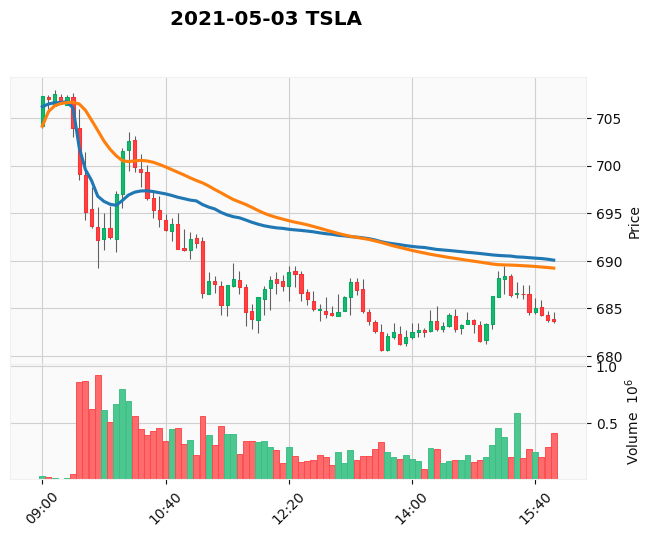

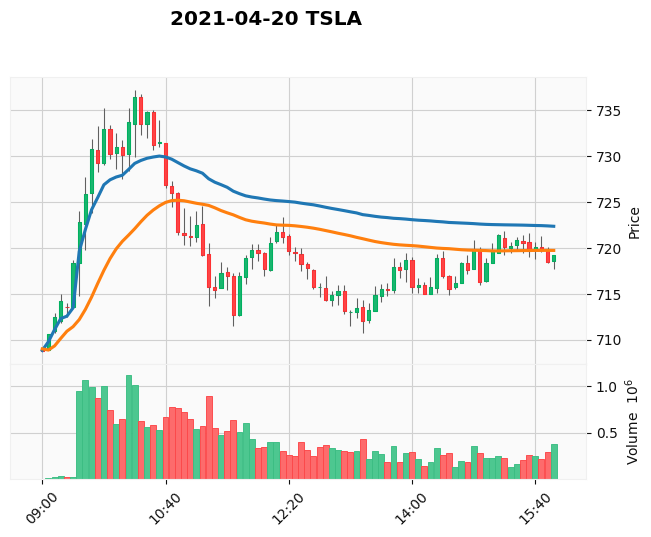

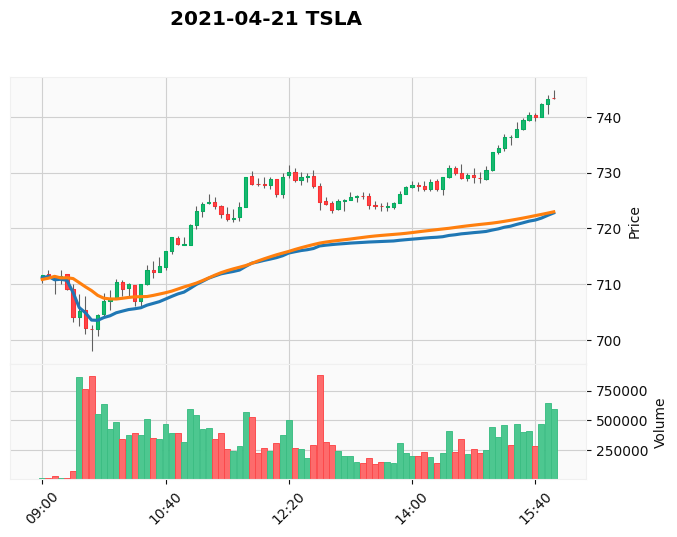

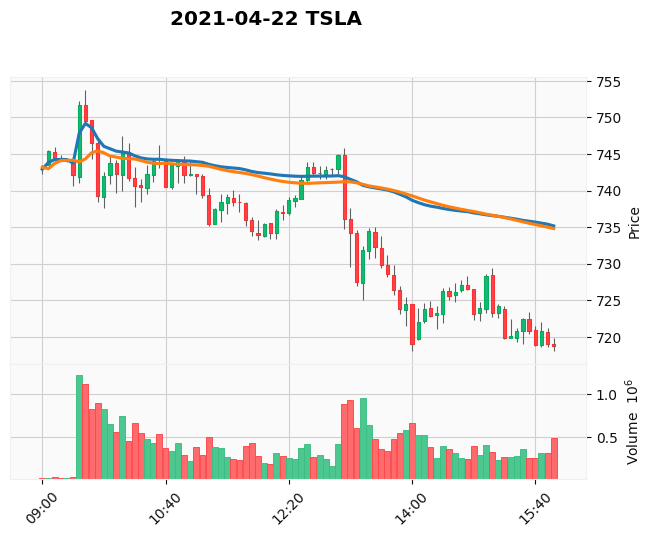

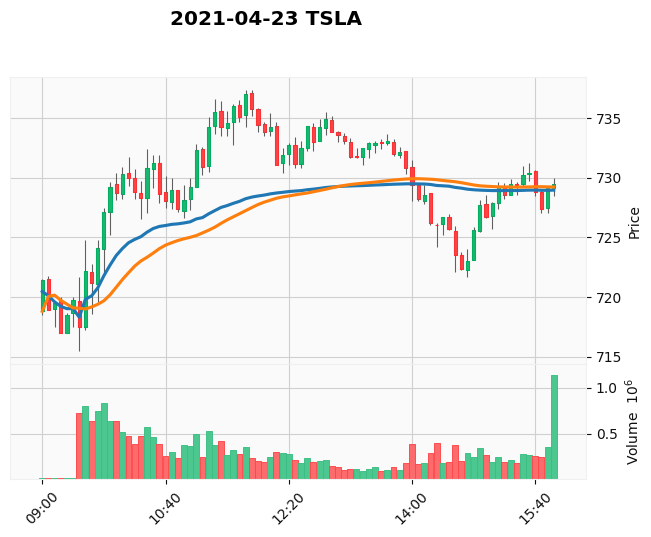

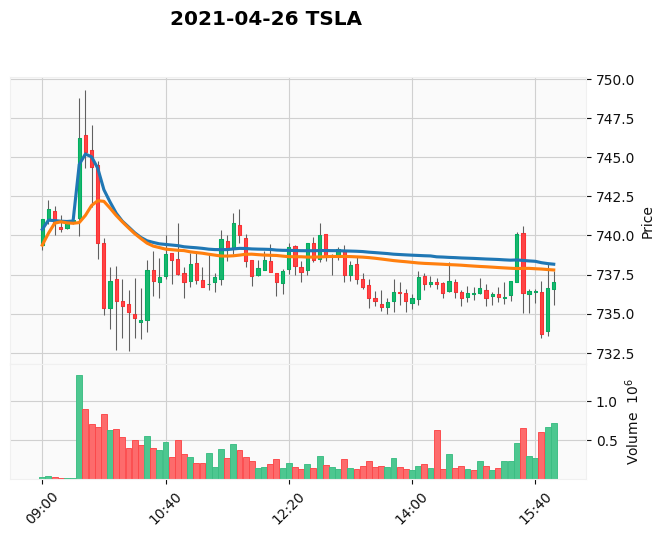

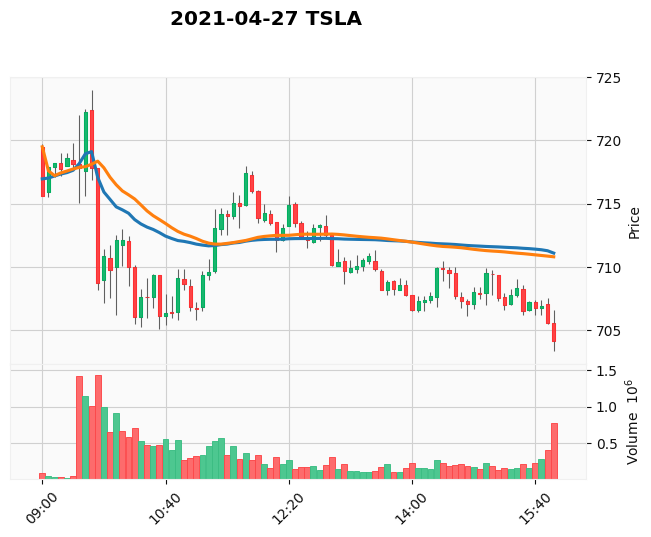

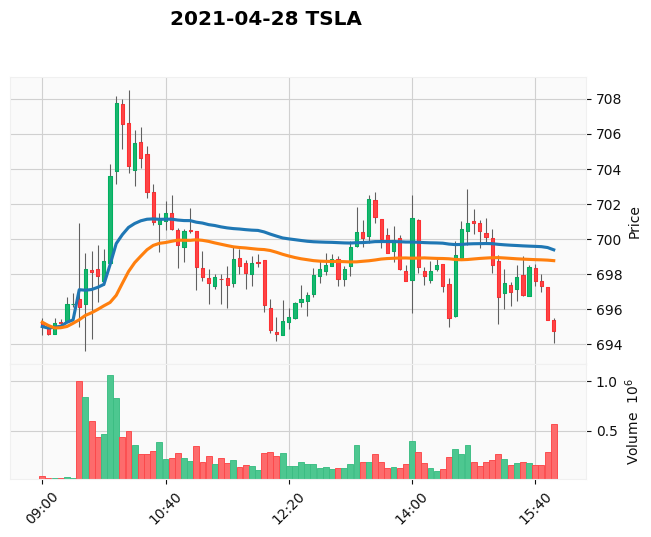

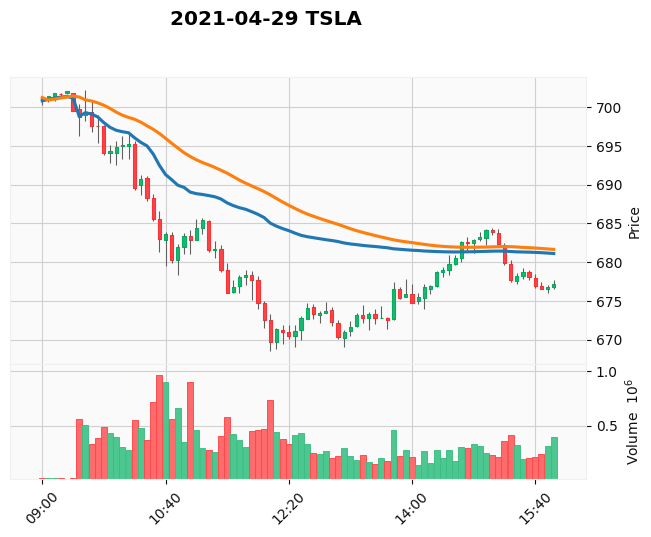

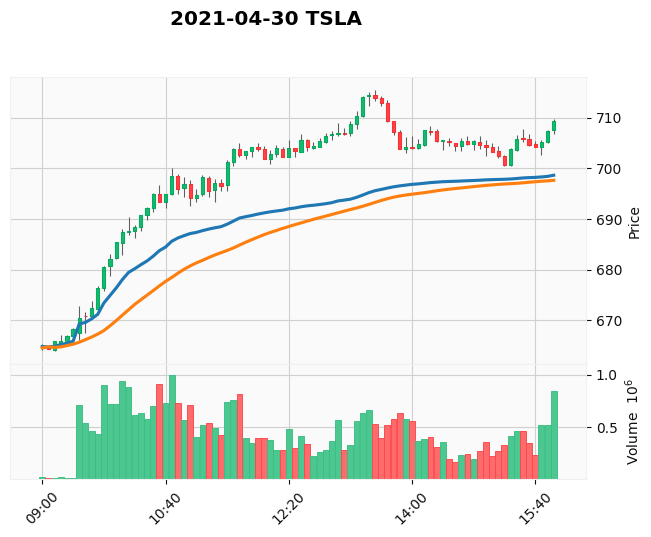

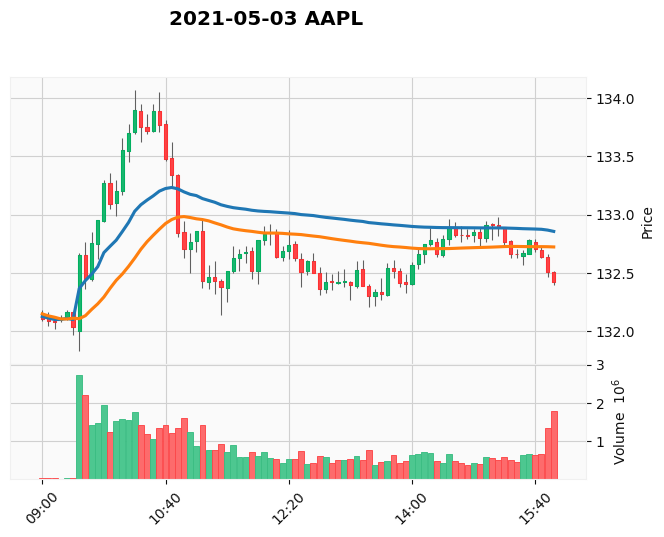

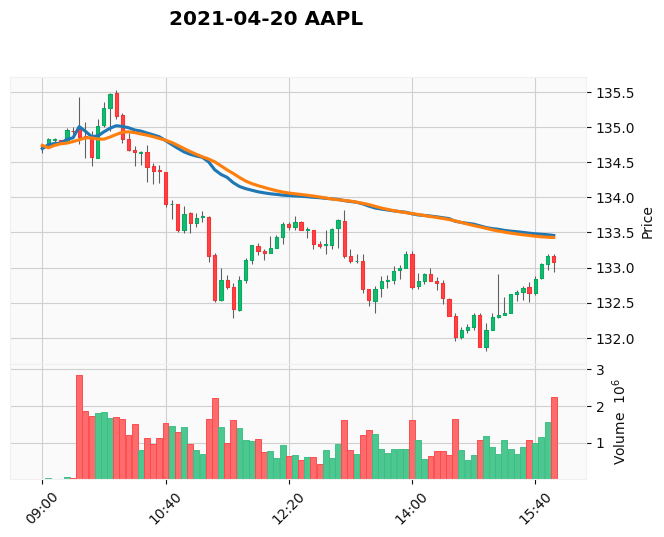

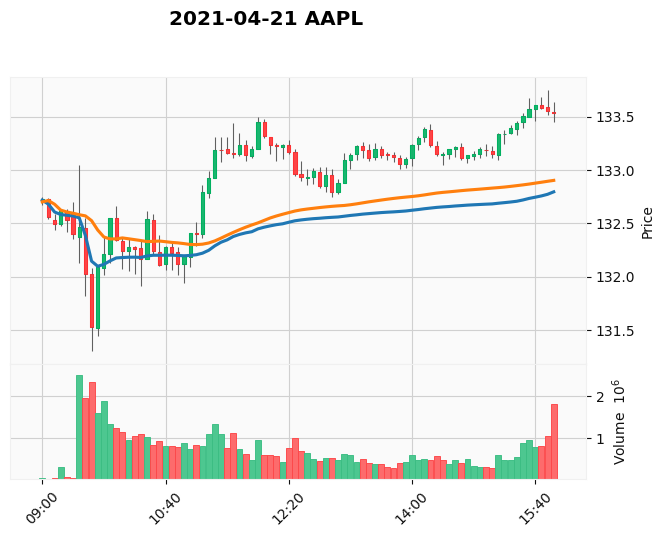

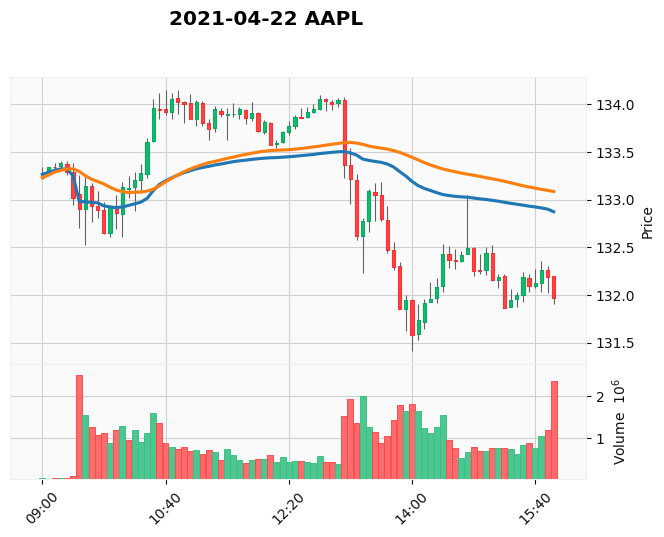

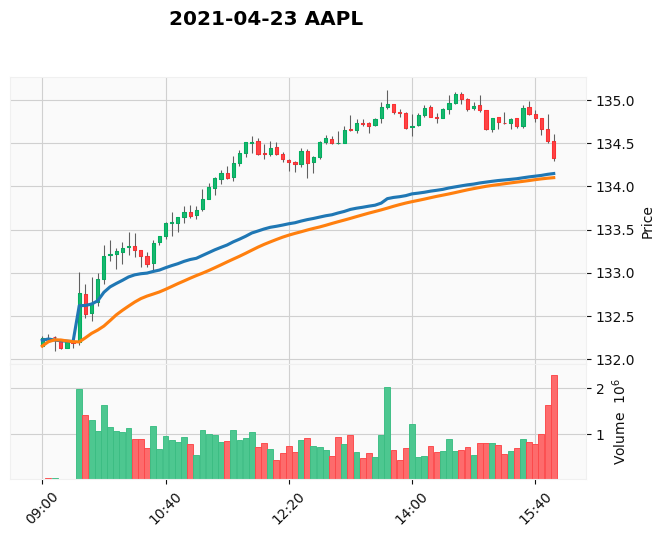

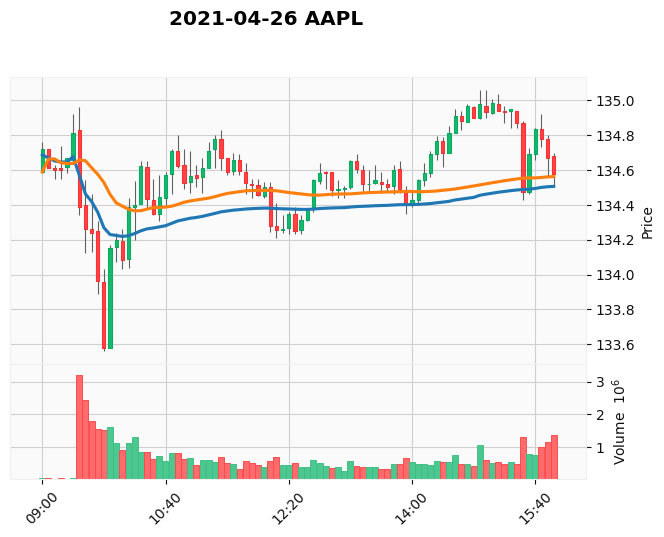

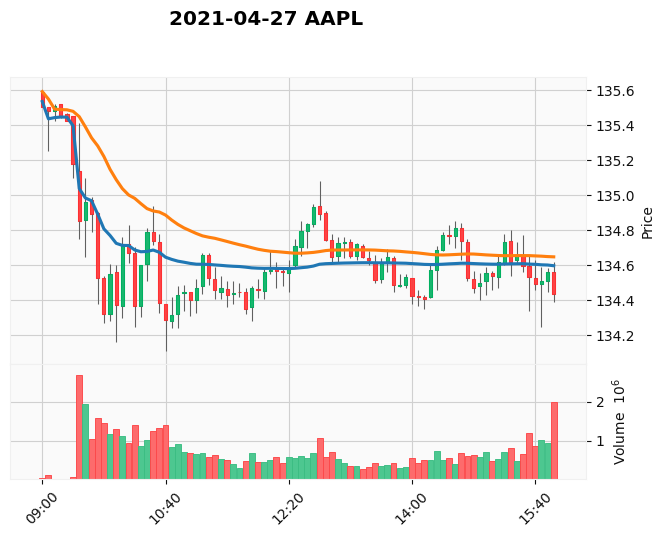

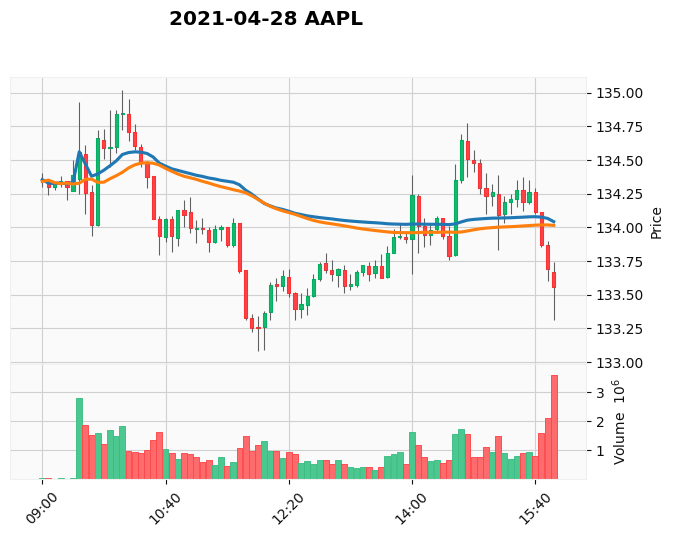

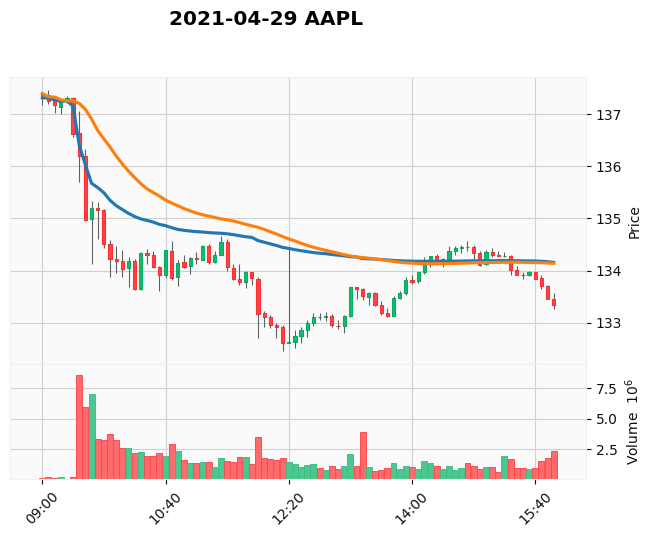

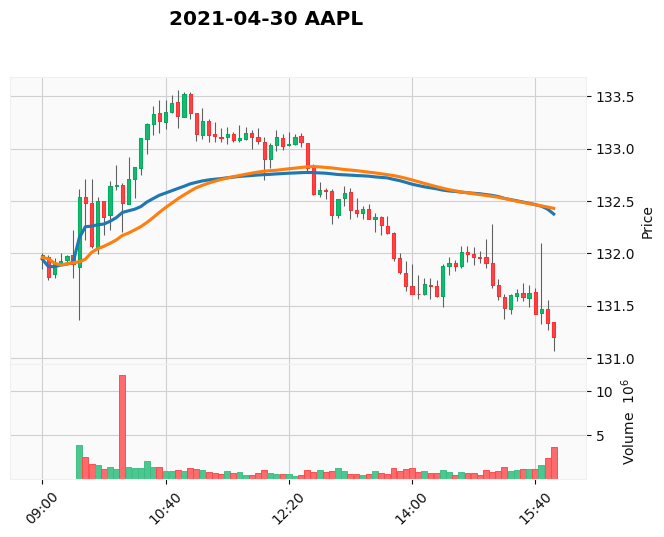

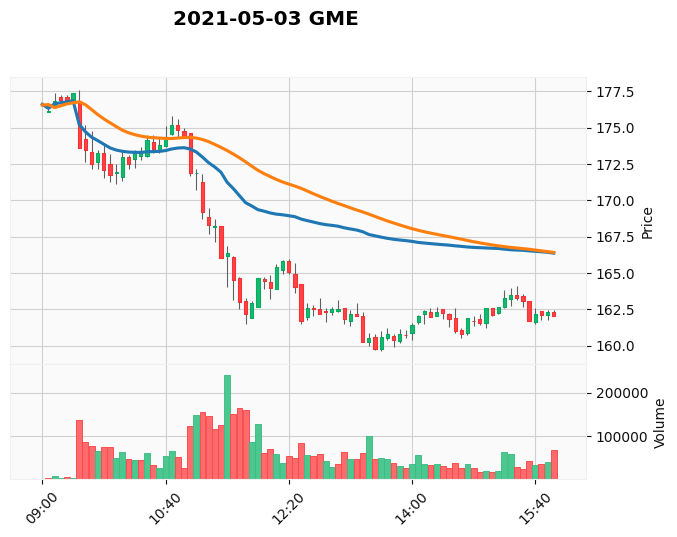

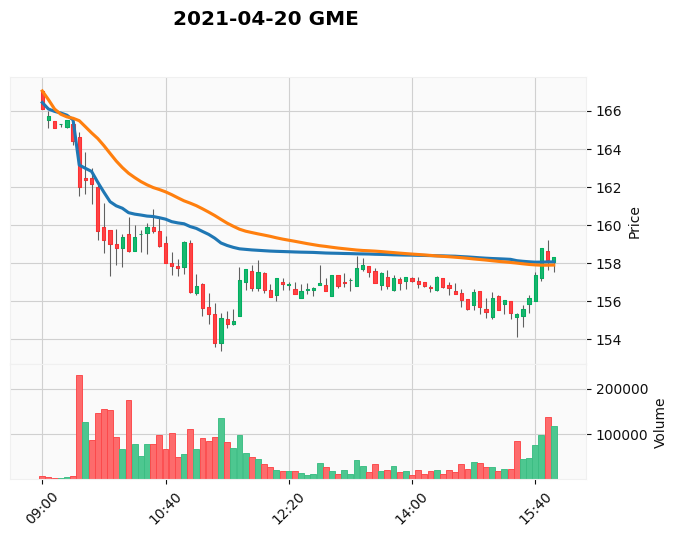

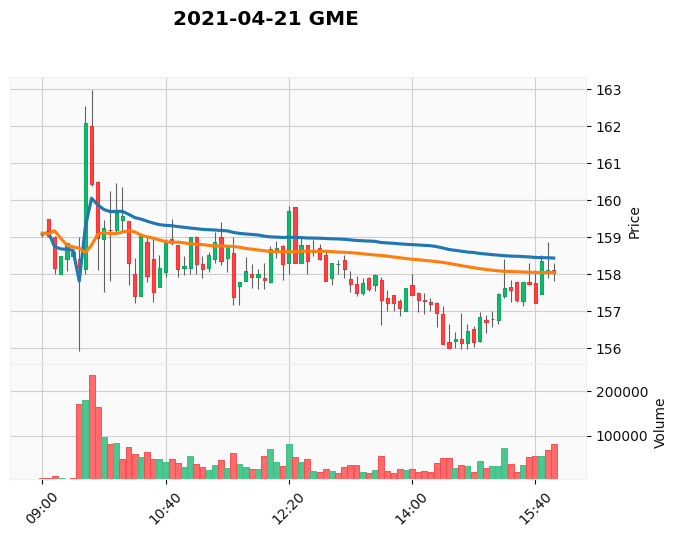

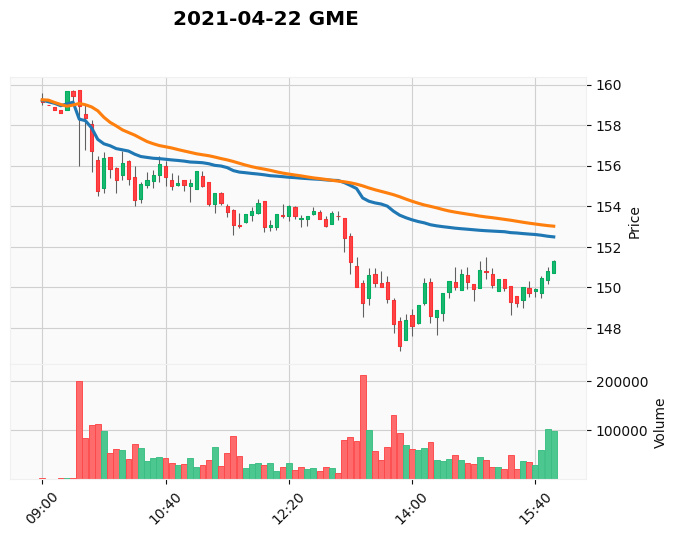

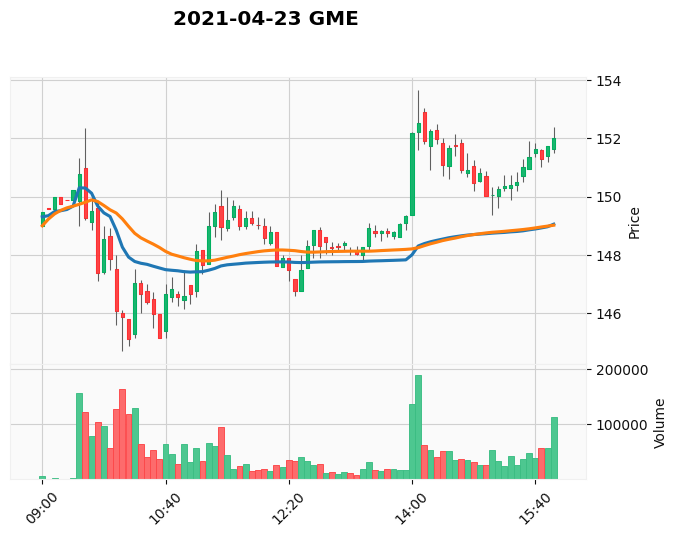

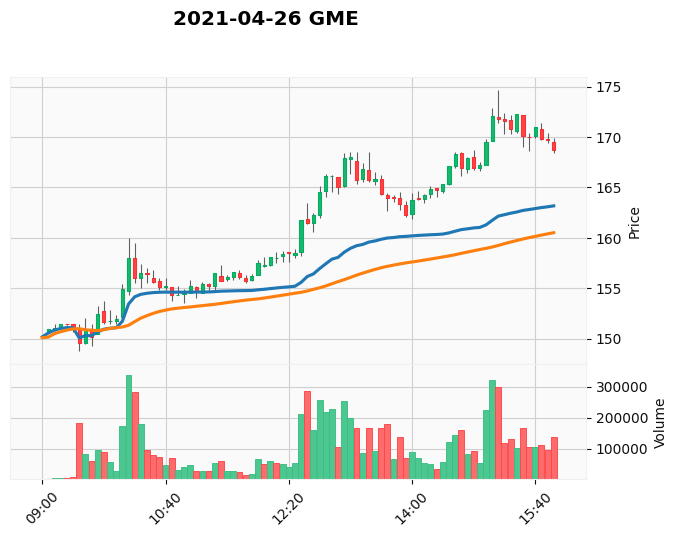

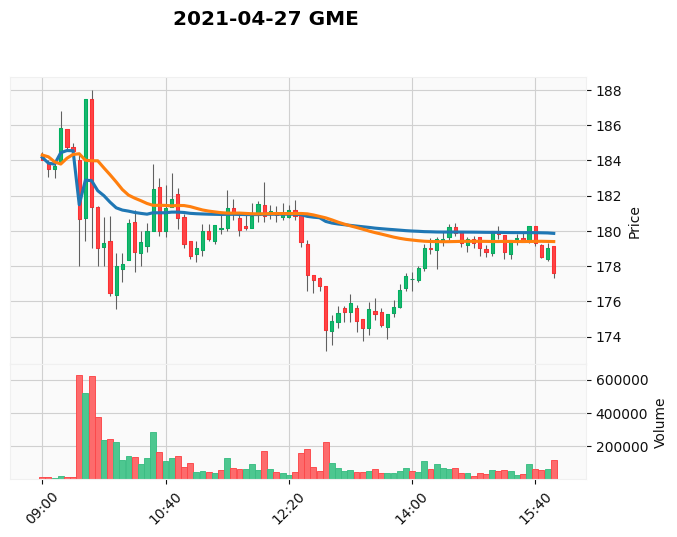

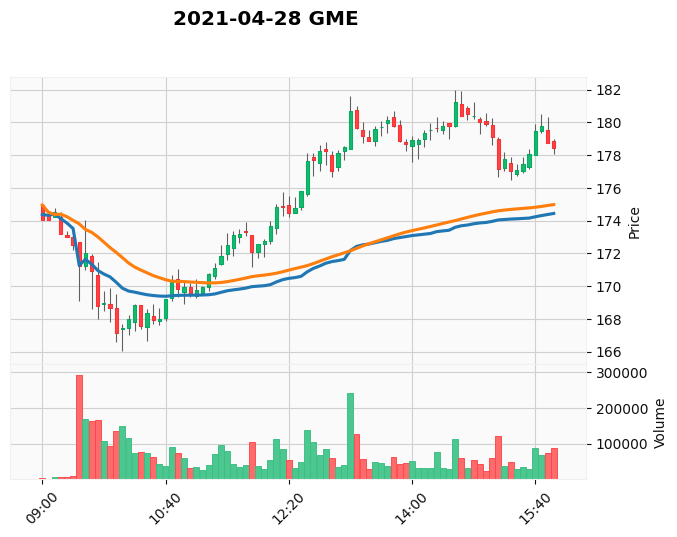

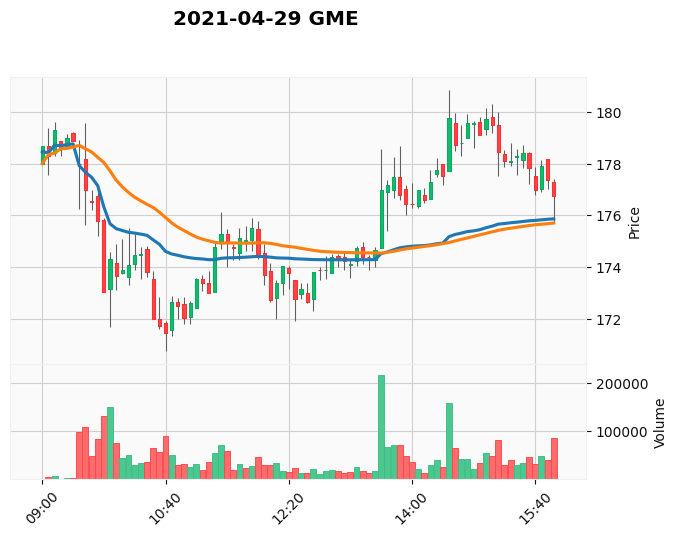

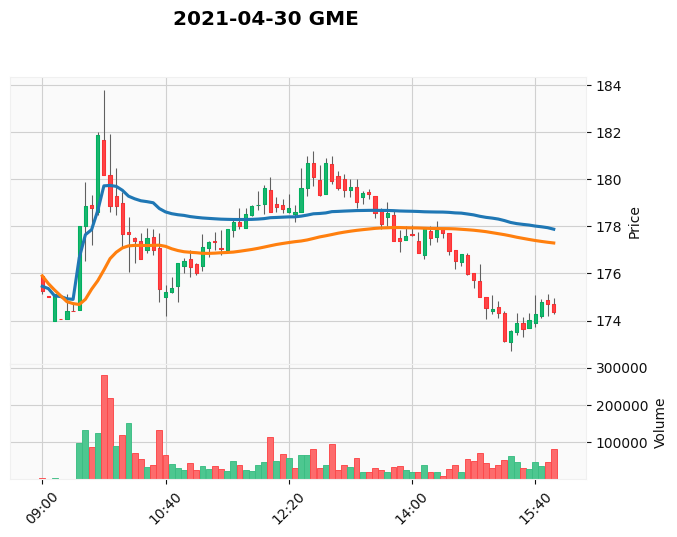

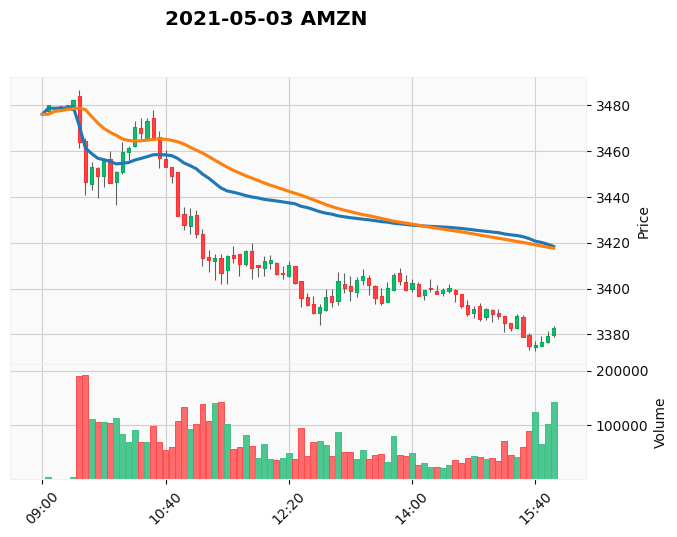

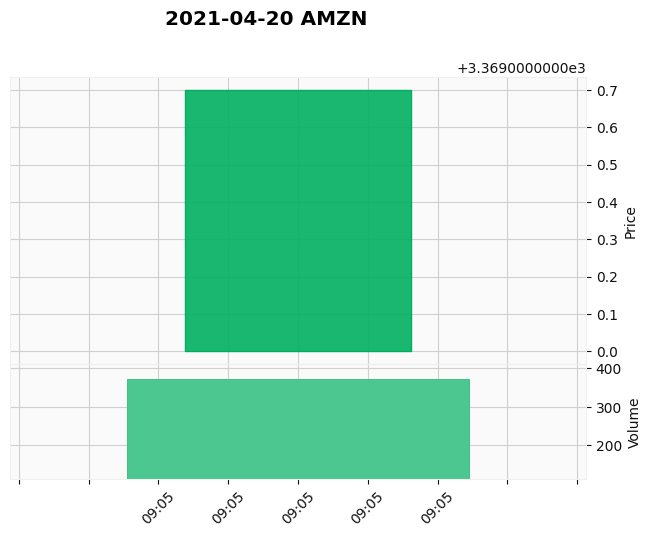

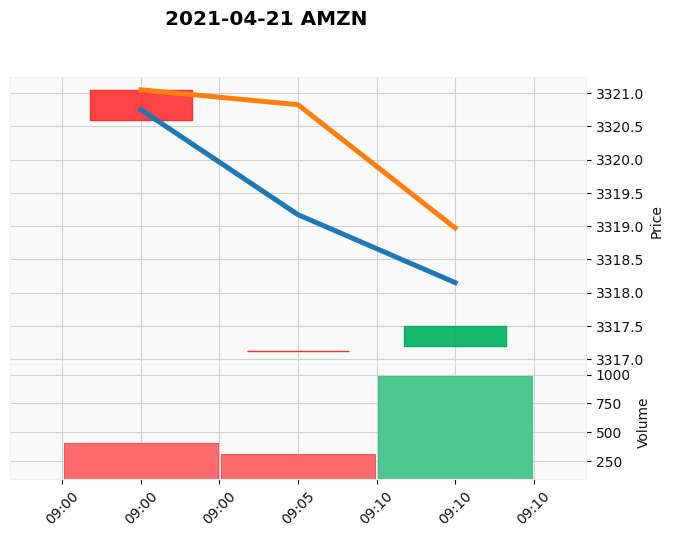

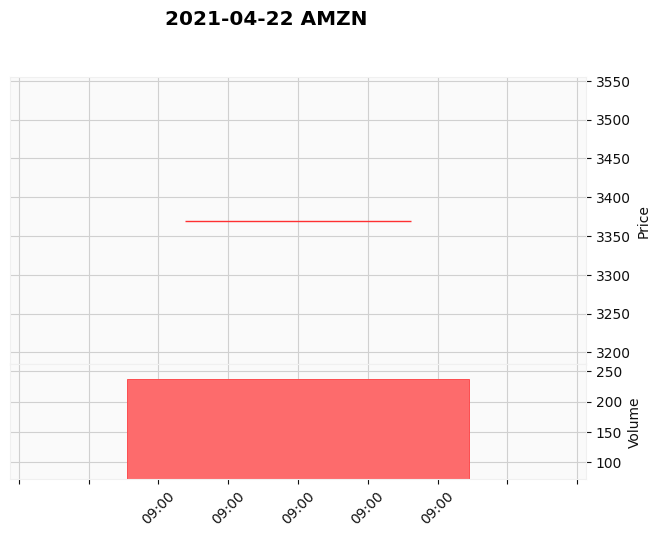

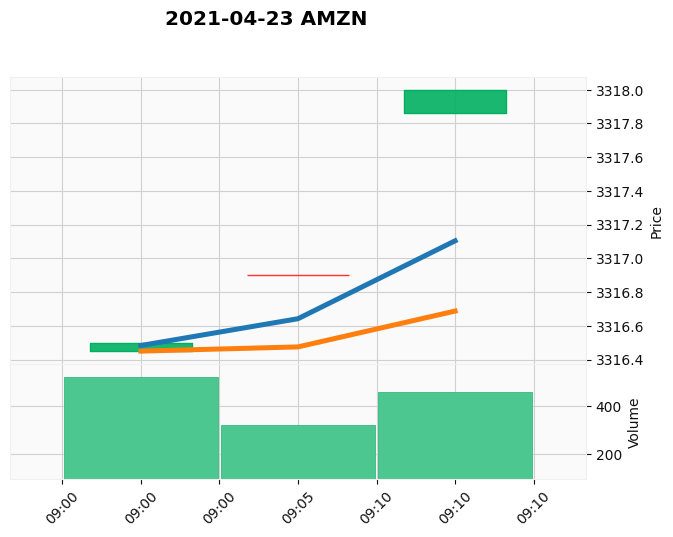

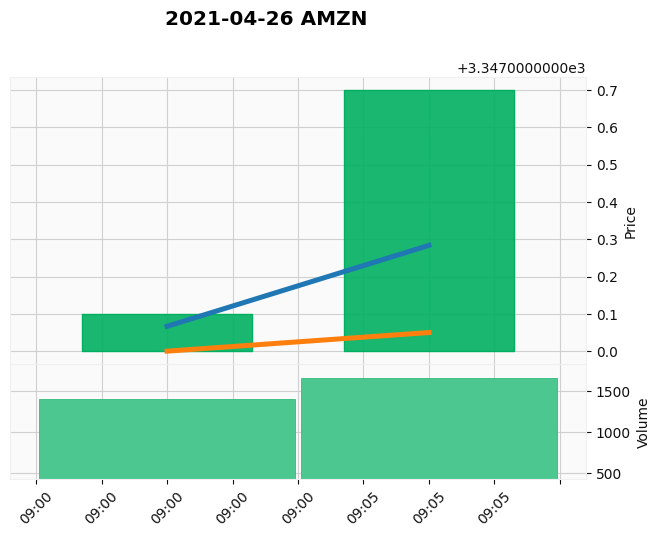

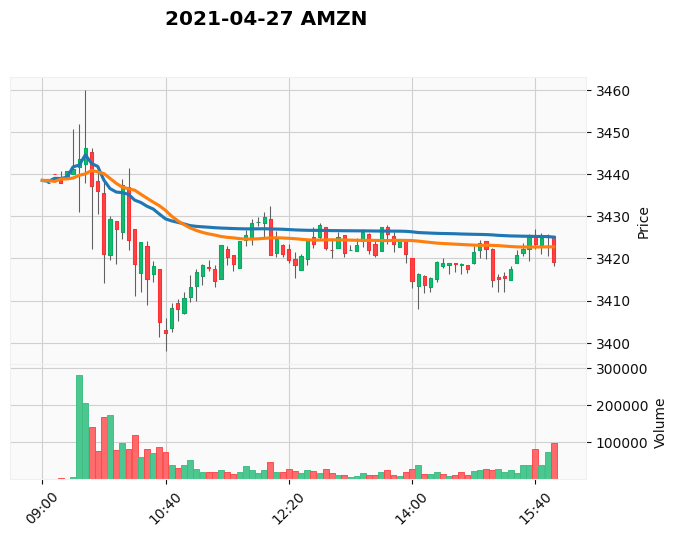

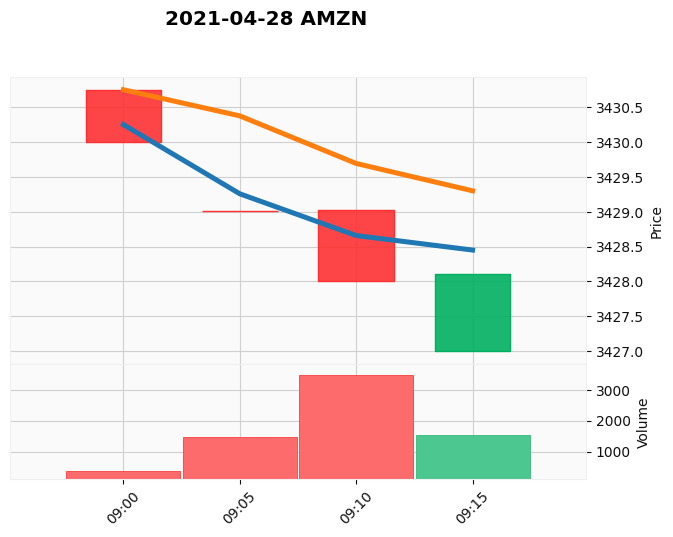

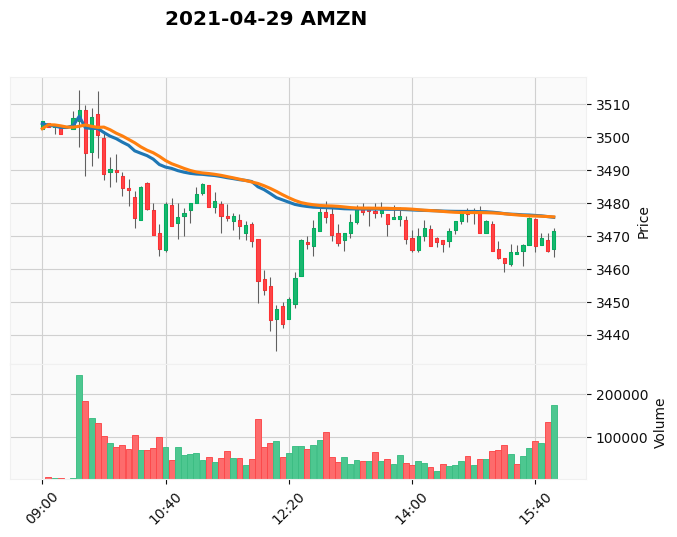

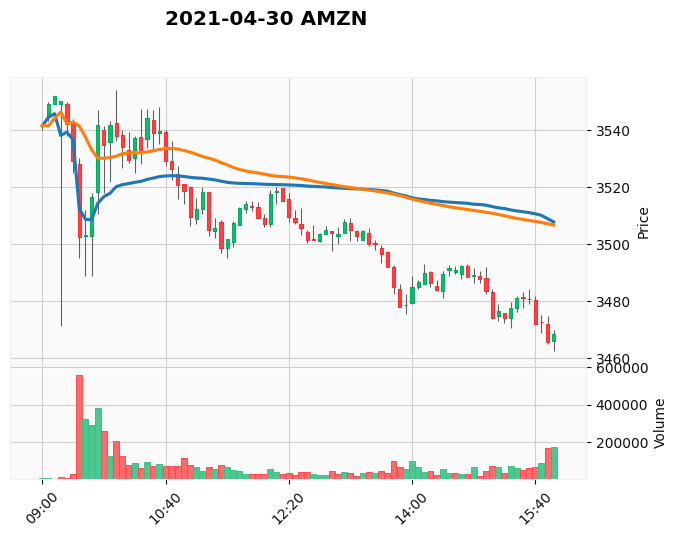

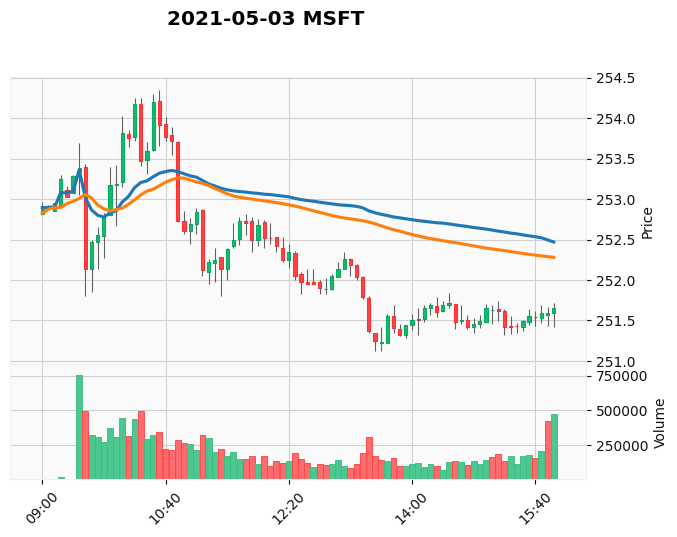

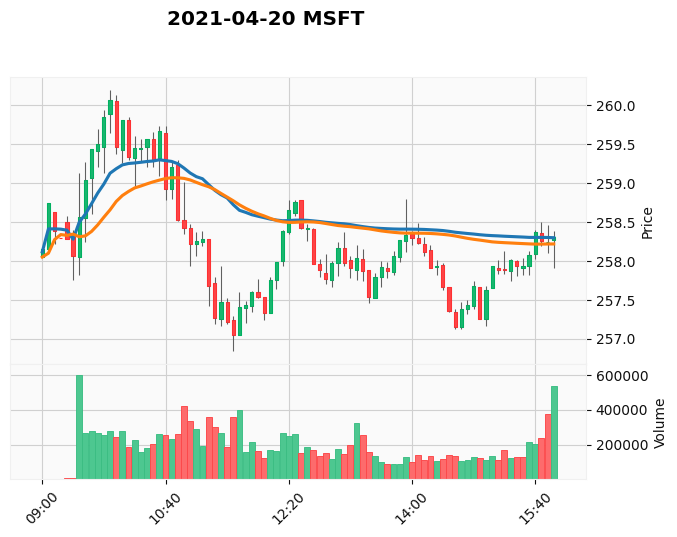

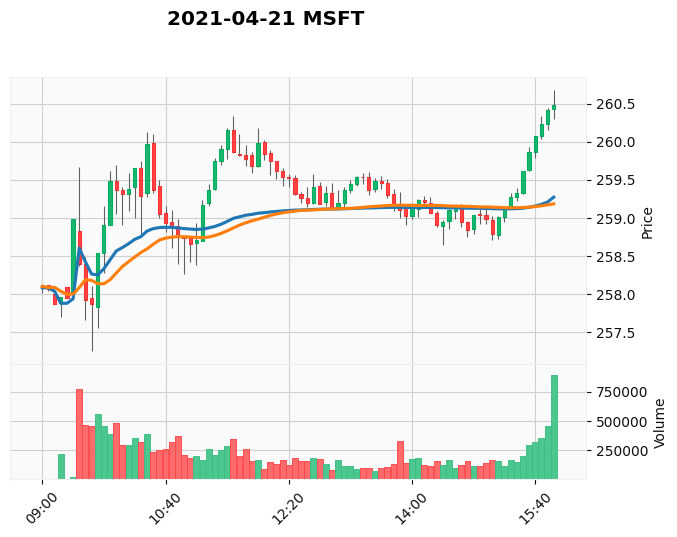

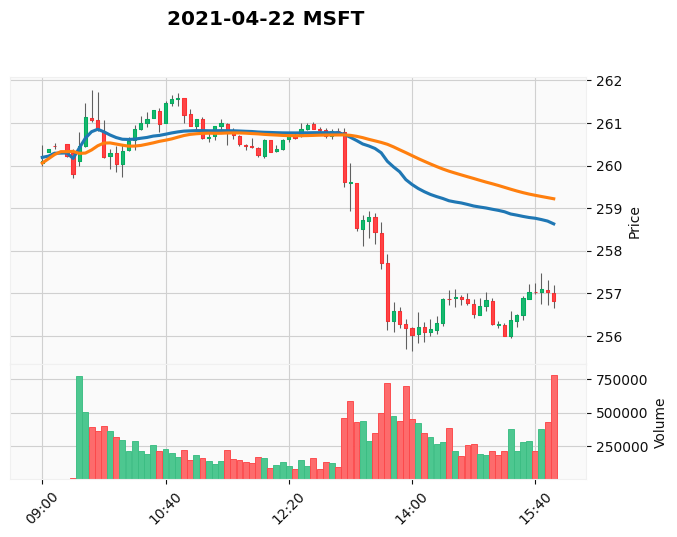

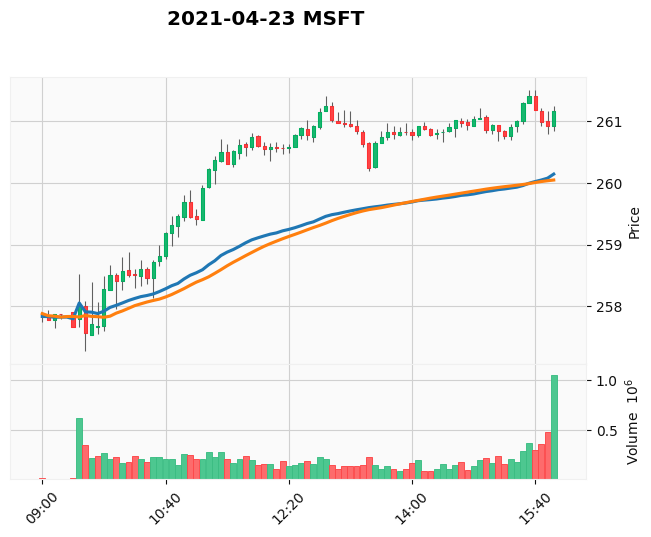

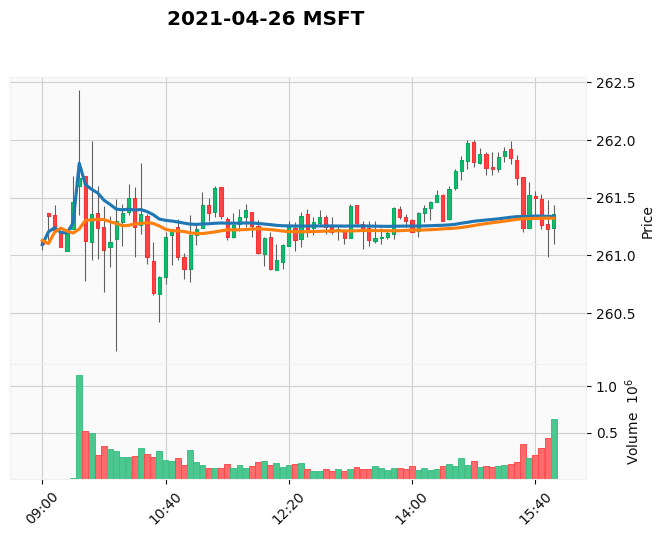

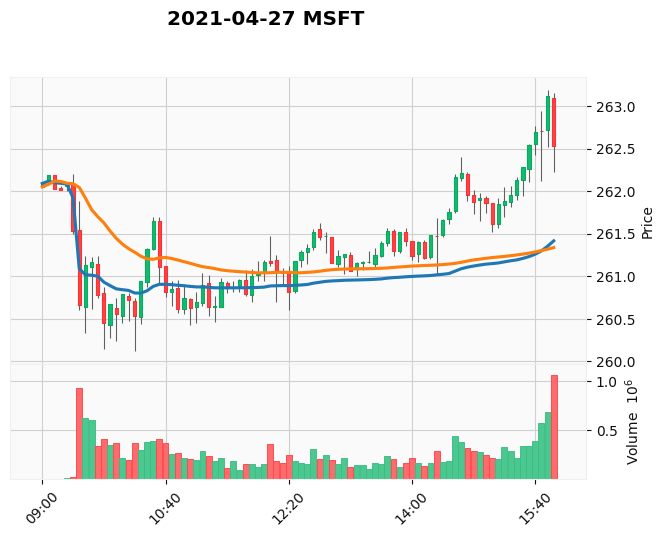

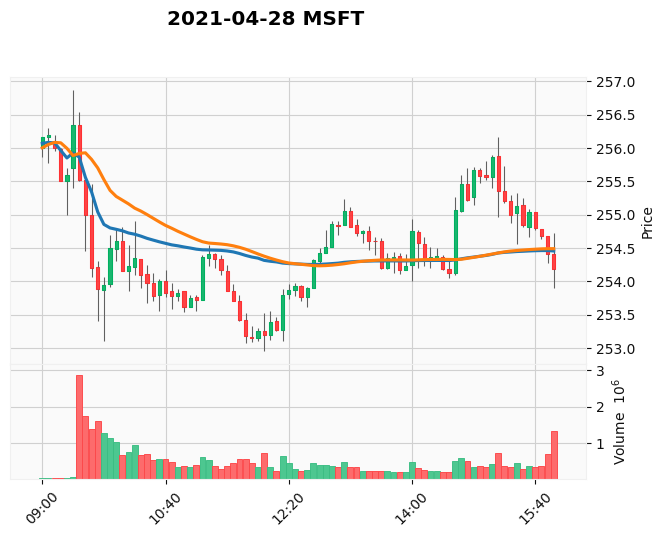

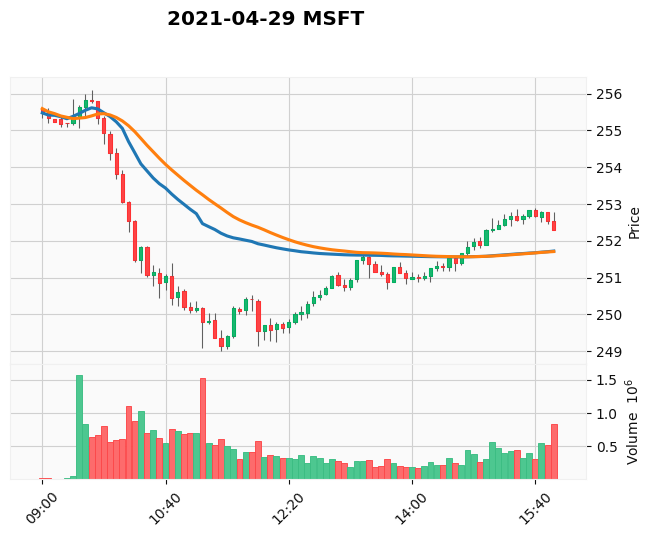

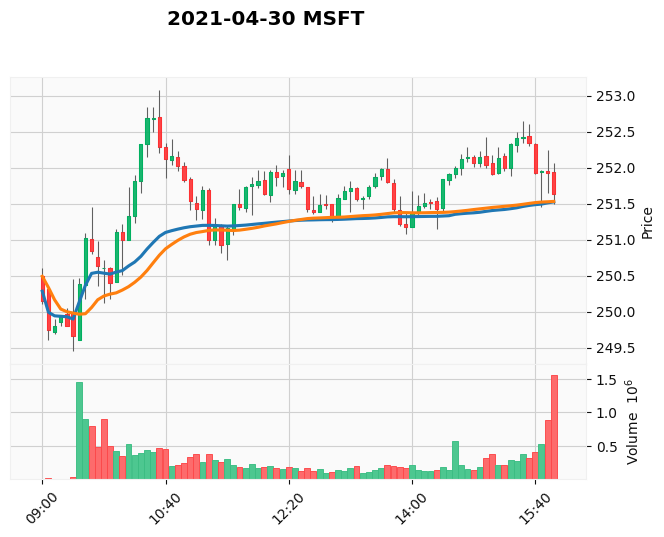

In [6]:
stocks = ['TSLA','AAPL','GME','AMZN','MSFT']

for stock in stocks:
    plot_data_frame(stock, 1000, add_vwap=1, add_twap=1)
